In [39]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import requests
import pandas as pd

api_key = "uYMAsRrLqjVAvJ4uqH27WJ6Mr9tir0JwTeMWmQ4W"

api_url = f"https://api.eia.gov/v2/electricity/state-electricity-profiles/source-disposition/data/?api_key={api_key}&frequency=annual&data[0]=estimated-losses&data[1]=facility-direct&data[2]=full-service-providers&data[3]=total-elect-indust&start=2010&end=2023&sort[0][column]=period&sort[0][direction]=desc&offset=140&length=5000"

# Fetch data from API
response = requests.get(api_url)

if response.status_code == 200:
    data = response.json()
    if "response" in data and "data" in data["response"]:
        df = pd.DataFrame(data["response"]["data"])
        df.to_csv("EIA_State_Electricity_Expanded.csv", index=False)
        print("Data downloaded and saved as 'EIA_State_Electricity_Expanded.csv'")
    else:
        print("Unexpected API response format. Please check the JSON structure.")
else:
    print(f"API request failed with status code {response.status_code}")

Data downloaded and saved as 'EIA_State_Electricity_Expanded.csv'


In [3]:
df.head()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust,estimated-losses-units,facility-direct-units,full-service-providers-units,total-elect-indust-units
0,2021,NC,North Carolina,6383881,151528,135541549,135693077,megawatthours,megawatthours,megawatthours,megawatthours
1,2021,NH,New Hampshire,511267,None,5772903,10867268,megawatthours,megawatthours,megawatthours,megawatthours
2,2021,MS,Mississippi,2258954,None,48015364,48015364,megawatthours,megawatthours,megawatthours,megawatthours
3,2021,MO,Missouri,3658477,None,77763041,77763041,megawatthours,megawatthours,megawatthours,megawatthours
4,2021,MN,Minnesota,3132786,810388,65778780,66589168,megawatthours,megawatthours,megawatthours,megawatthours


## OK so now we got our dataset 

## lets start with Exploratory Data Analysis (EDA)

In [4]:
df.shape

(588, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   period                        588 non-null    object
 1   state                         588 non-null    object
 2   stateDescription              588 non-null    object
 3   estimated-losses              588 non-null    object
 4   facility-direct               359 non-null    object
 5   full-service-providers        588 non-null    object
 6   total-elect-indust            588 non-null    object
 7   estimated-losses-units        588 non-null    object
 8   facility-direct-units         588 non-null    object
 9   full-service-providers-units  588 non-null    object
 10  total-elect-indust-units      588 non-null    object
dtypes: object(11)
memory usage: 50.7+ KB


In [6]:
df.describe()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust,estimated-losses-units,facility-direct-units,full-service-providers-units,total-elect-indust-units
count,588,588,588,588,359,588,588,588,588,588,588
unique,12,52,52,588,337,588,588,1,1,1,1
top,2020,NC,North Carolina,6383881,0,135541549,135693077,megawatthours,megawatthours,megawatthours,megawatthours
freq,52,12,12,1,23,1,1,588,588,588,588


# Data Cleaning

## first will drop unnecessary columns

In [7]:
df.columns

Index(['period', 'state', 'stateDescription', 'estimated-losses',
       'facility-direct', 'full-service-providers', 'total-elect-indust',
       'estimated-losses-units', 'facility-direct-units',
       'full-service-providers-units', 'total-elect-indust-units'],
      dtype='object')

In [8]:
df.drop(['estimated-losses-units', 'facility-direct-units',
       'full-service-providers-units', 'total-elect-indust-units'],axis='columns',inplace=True)

In [9]:
df.head()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust
0,2021,NC,North Carolina,6383881,151528,135541549,135693077
1,2021,NH,New Hampshire,511267,None,5772903,10867268
2,2021,MS,Mississippi,2258954,None,48015364,48015364
3,2021,MO,Missouri,3658477,None,77763041,77763041
4,2021,MN,Minnesota,3132786,810388,65778780,66589168


## lets go with handling missing values

In [10]:
df.isna().sum()

period                      0
state                       0
stateDescription            0
estimated-losses            0
facility-direct           229
full-service-providers      0
total-elect-indust          0
dtype: int64

## as we can see there are 230 missing values in facility direct

## Facility direct means electricity directly sold to customers hence we can't drop rows for this column because the data is crucial to us

In [11]:
df.fillna(0,inplace=True)

In [12]:
df.isna().sum()

period                    0
state                     0
stateDescription          0
estimated-losses          0
facility-direct           0
full-service-providers    0
total-elect-indust        0
dtype: int64

## Great!!! we got rid of all missing values in our dataset.

## checking and dropping for duplicate records

In [13]:
df_new = df.drop_duplicates()

In [14]:
df_new.shape

(588, 7)

## hence there were no duplicates

## checking dtypes

In [15]:
df.head()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust
0,2021,NC,North Carolina,6383881,151528,135541549,135693077
1,2021,NH,New Hampshire,511267,0,5772903,10867268
2,2021,MS,Mississippi,2258954,0,48015364,48015364
3,2021,MO,Missouri,3658477,0,77763041,77763041
4,2021,MN,Minnesota,3132786,810388,65778780,66589168


In [16]:
df.dtypes

period                    object
state                     object
stateDescription          object
estimated-losses          object
facility-direct           object
full-service-providers    object
total-elect-indust        object
dtype: object

In [17]:
df.columns

Index(['period', 'state', 'stateDescription', 'estimated-losses',
       'facility-direct', 'full-service-providers', 'total-elect-indust'],
      dtype='object')

In [18]:
df['period']=df.period.astype('int64')
df['estimated-losses']=df['estimated-losses'].astype('int64')
df['facility-direct']=df['facility-direct'].astype('float64')
df['full-service-providers']=df['full-service-providers'].astype('int64')
df['total-elect-indust']=df['total-elect-indust'].astype('int64')

In [19]:
df.dtypes

period                      int64
state                      object
stateDescription           object
estimated-losses            int64
facility-direct           float64
full-service-providers      int64
total-elect-indust          int64
dtype: object

## we changed our dtypes for our dataset

## checking inconsistencies in categorical variable

In [20]:
df.state.unique()

array(['NC', 'NH', 'MS', 'MO', 'MN', 'MI', 'ME', 'NM', 'NJ', 'PA', 'OR',
       'OK', 'OH', 'NY', 'NV', 'MT', 'NE', 'WY', 'WV', 'WI', 'WA', 'VT',
       'VA', 'UT', 'US', 'TX', 'TN', 'SD', 'SC', 'RI', 'LA', 'KY', 'KS',
       'IN', 'IL', 'ID', 'IA', 'HI', 'GA', 'FL', 'DE', 'DC', 'CT', 'CO',
       'CA', 'AZ', 'AR', 'AL', 'AK', 'MD', 'MA', 'ND'], dtype=object)

In [21]:
df.stateDescription.unique()

array(['North Carolina', 'New Hampshire', 'Mississippi', 'Missouri',
       'Minnesota', 'Michigan', 'Maine', 'New Mexico', 'New Jersey',
       'Pennsylvania', 'Oregon', 'Oklahoma', 'Ohio', 'New York', 'Nevada',
       'Montana', 'Nebraska', 'Wyoming', 'West Virginia', 'Wisconsin',
       'Washington', 'Vermont', 'Virginia', 'Utah', 'United States',
       'Texas', 'Tennessee', 'South Dakota', 'South Carolina',
       'Rhode Island', 'Louisiana', 'Kentucky', 'Kansas', 'Indiana',
       'Illinois', 'Idaho', 'Iowa', 'Hawaii', 'Georgia', 'Florida',
       'Delaware', 'District of Columbia', 'Connecticut', 'Colorado',
       'California', 'Arizona', 'Arkansas', 'Alabama', 'Alaska',
       'Maryland', 'Massachusetts', 'North Dakota'], dtype=object)

## see there is a value "United States" present which is not appropriate as we're performing analysis states in United States. Hence will filter out those records. 

In [22]:
df_cleaned = df[df.stateDescription!="United States"].reset_index(drop=True)

In [23]:
df_cleaned.head()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust
0,2021,NC,North Carolina,6383881,151528.0,135541549,135693077
1,2021,NH,New Hampshire,511267,0.0,5772903,10867268
2,2021,MS,Mississippi,2258954,0.0,48015364,48015364
3,2021,MO,Missouri,3658477,0.0,77763041,77763041
4,2021,MN,Minnesota,3132786,810388.0,65778780,66589168


# Exploratory Data Analysis (EDA)

### Trends and patterns in the data

In [24]:
df_eda = df_cleaned.copy()
df_eda.head()

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust
0,2021,NC,North Carolina,6383881,151528.0,135541549,135693077
1,2021,NH,New Hampshire,511267,0.0,5772903,10867268
2,2021,MS,Mississippi,2258954,0.0,48015364,48015364
3,2021,MO,Missouri,3658477,0.0,77763041,77763041
4,2021,MN,Minnesota,3132786,810388.0,65778780,66589168


In [25]:
df_eda.describe()

,period,estimated-losses,facility-direct,full-service-providers,total-elect-indust
count,577.000000,5.770000e+02,5.770000e+02,5.770000e+02,5.770000e+02
mean,2015.166378,4.009297e+06,2.578675e+05,6.260594e+07,7.361465e+07
std,3.272897,3.894058e+06,1.052269e+06,6.657341e+07,7.110345e+07
min,2010.000000,2.754240e+05,0.000000e+00,1.515880e+05,5.331458e+06
25%,2012.000000,1.240371e+06,0.000000e+00,2.047540e+07,2.311522e+07
50%,2015.000000,3.064779e+06,2.328000e+03,4.708030e+07,5.556991e+07
75%,2018.000000,5.318146e+06,9.845800e+04,8.337832e+07,9.701191e+07
max,2021.000000,2.377384e+07,1.001126e+07,4.217067e+08,4.293434e+08


## total electricity consumption feature distribution 

In [26]:
df_eda.columns

Index(['period', 'state', 'stateDescription', 'estimated-losses',
       'facility-direct', 'full-service-providers', 'total-elect-indust'],
      dtype='object')

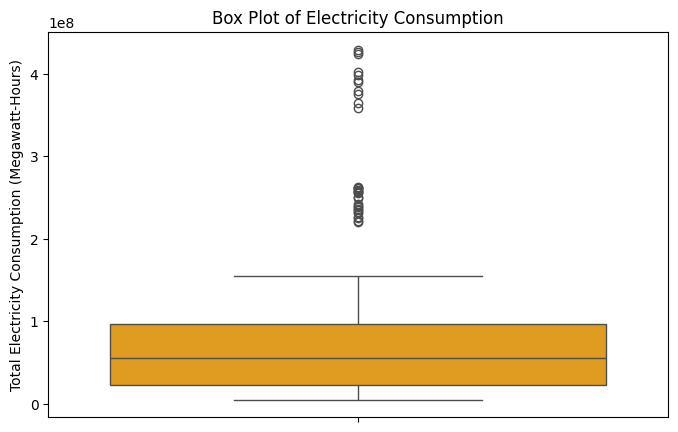

In [27]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(y=df_cleaned["total-elect-indust"], color="orange")
plt.ylabel("Total Electricity Consumption (Megawatt-Hours)")
plt.title("Box Plot of Electricity Consumption")
plt.show()

## we can determine there are few records which are outliers

### the graph is right skewed, it says few states has relatively low consumption of electricity.

### there are few states which uses a higher consumption of electricity. Lets know where ?

In [28]:
Q1 = df_eda['total-elect-indust'].quantile(0.25)
Q3 = df_eda['total-elect-indust'].quantile(0.75)

IQR = Q3-Q1

#defining upper threshold
upper = Q3 + 1.5*IQR

In [29]:
outlier_states = df_eda[df_eda['total-elect-indust']>upper][['stateDescription','total-elect-indust']]

In [30]:
outlier_states.stateDescription.unique()

array(['Texas', 'Florida', 'California'], dtype=object)

## Hence,Texas, Florida and California are the 3 states which are more power consuming. Possible reason could be they are industrial areas.

## Trends over Year

## Total electricity consumption over years

In [31]:
df_eda.columns

Index(['period', 'state', 'stateDescription', 'estimated-losses',
       'facility-direct', 'full-service-providers', 'total-elect-indust'],
      dtype='object')

In [32]:
df_eda.head(3)

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust
0,2021,NC,North Carolina,6383881,151528.0,135541549,135693077
1,2021,NH,New Hampshire,511267,0.0,5772903,10867268
2,2021,MS,Mississippi,2258954,0.0,48015364,48015364


In [33]:
df_eda['total-elect-indust in millions'] = (df['total-elect-indust']/1000000).round(2)
df_eda.head(3)

,period,state,stateDescription,estimated-losses,facility-direct,full-service-providers,total-elect-indust,total-elect-indust in millions
0,2021,NC,North Carolina,6383881,151528.0,135541549,135693077,135.69
1,2021,NH,New Hampshire,511267,0.0,5772903,10867268,10.87
2,2021,MS,Mississippi,2258954,0.0,48015364,48015364,48.02


In [34]:
# Sum total electricity consumption for each year
yearly_consumption = df_eda.groupby("period")["total-elect-indust in millions"].sum()
yearly_consumption

period
2010    3716.70
2011    7396.30
2012    7262.11
2013    7416.02
2014    7637.52
2015    7233.02
2016    7274.50
2017    7893.74
2018    7343.50
2019    7508.06
2020    7384.33
2021    1153.92
Name: total-elect-indust in millions, dtype: float64

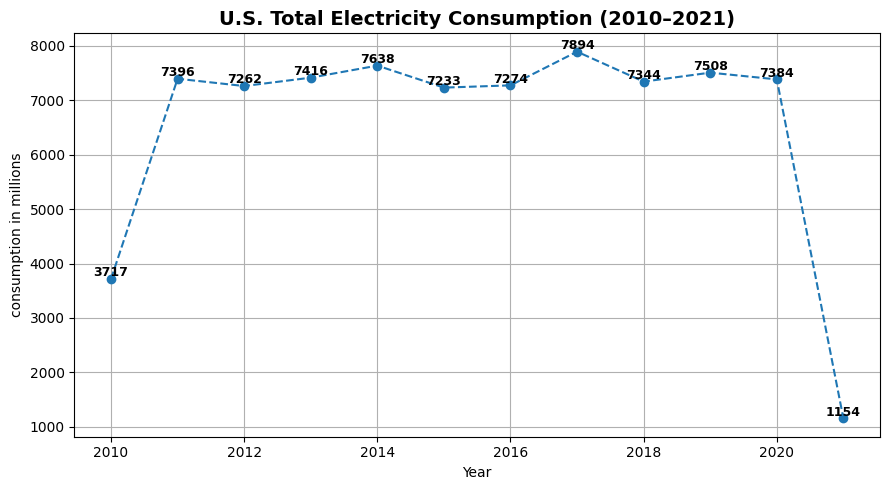

In [35]:
plt.figure(figsize=(9,5))
plt.plot(yearly_consumption.index,yearly_consumption.values,marker='o',linestyle='--')
plt.title("U.S. Total Electricity Consumption (2010–2021)", fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.grid(True)
plt.ylabel('consumption in millions')

for x, y in zip(yearly_consumption.index, yearly_consumption.values):
    plt.text(x, y + 50, f"{y:.0f}", ha='center', fontsize=9, fontweight='bold')


plt.tight_layout()
plt.show()

## the  graph shows a steady fluctuations in energy consumption from 2011 to 2020, suggesting us a steady national demand.
## the drop in 2021 suggests us that this is an outlier as there are rare chances tend to negligible that the consumption dropping of electrcity because this was the time corona entered and people were forced to stay in home. This probably might could be an outlier.

# State Level Trends

## getting top 5 states of high consumption

In [37]:
# Step 1: Group by state and year
state_yearly = df_eda.groupby(["stateDescription", "period"])["total-elect-indust in millions"].sum().reset_index()

# Step 2: Filter out extreme values
state_yearly_filtered = state_yearly[state_yearly["total-elect-indust in millions"] < 1000]

# ✅ Step 3: Get the REAL top 5 states from the filtered data
top_nstates = (
    state_yearly_filtered
    .groupby("stateDescription")["total-elect-indust in millions"]
    .sum()
    .nlargest(5)
    .index
)

# Step 4: Filter dataset to only include those top states
topn_state_yearly = state_yearly_filtered[state_yearly_filtered["stateDescription"].isin(top_nstates)]


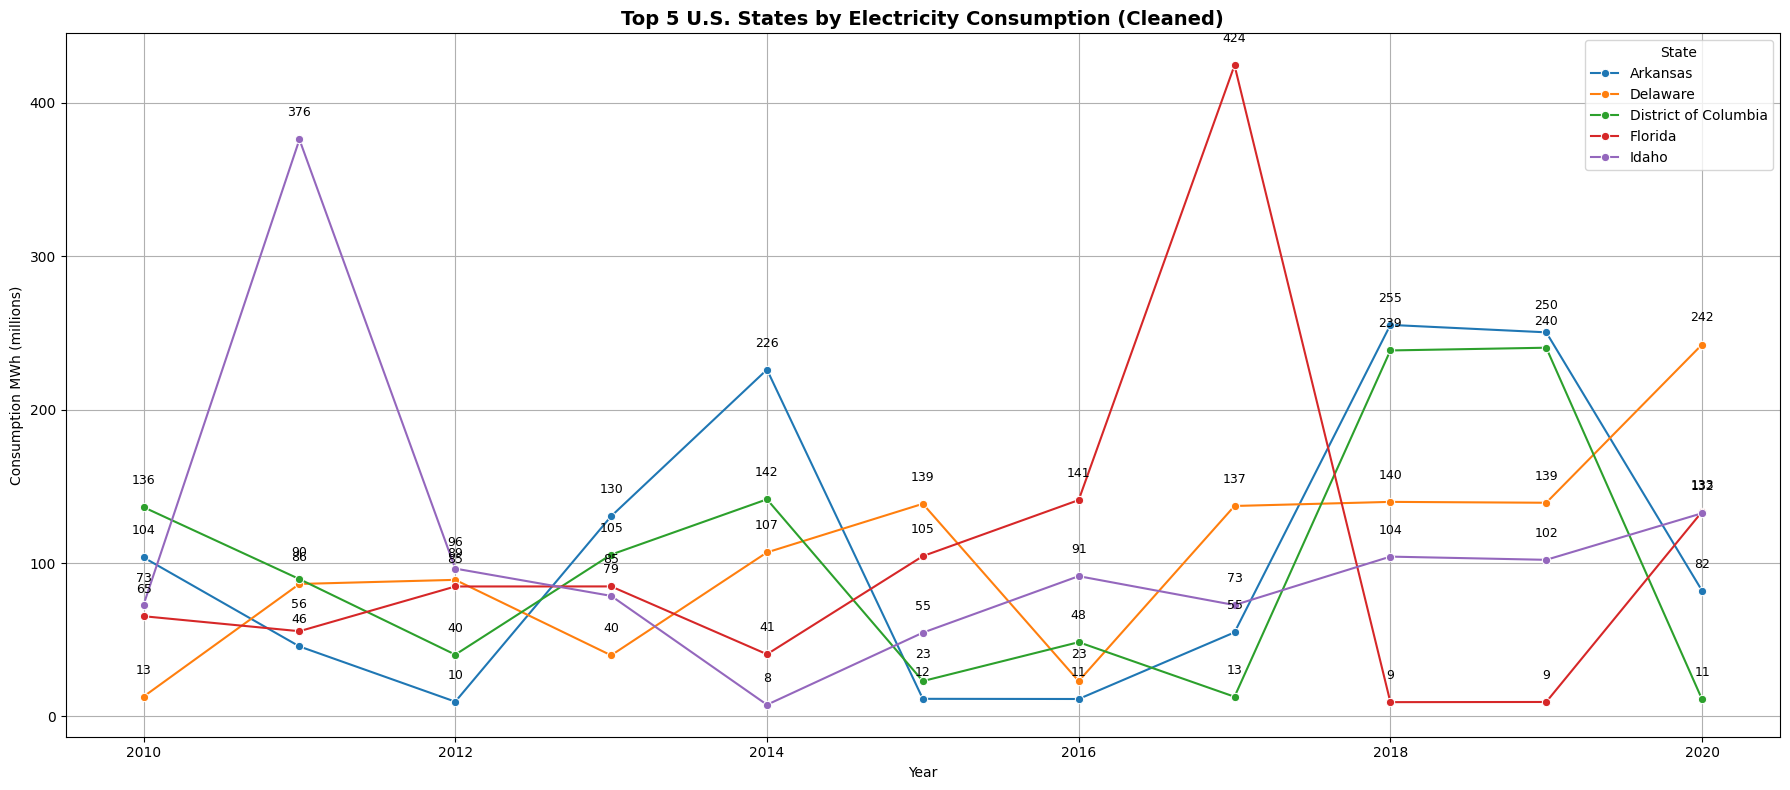

In [38]:
plt.figure(figsize=(18, 8))
sns.lineplot(data=topn_state_yearly, x='period', y='total-elect-indust in millions',
             hue='stateDescription', marker='o')

# Annotate each point
for state in topn_state_yearly['stateDescription'].unique():
    state_data = topn_state_yearly[topn_state_yearly['stateDescription'] == state]
    for x, y in zip(state_data['period'], state_data['total-elect-indust in millions']):
        plt.text(x, y + 15, f"{y:.0f}", ha='center', fontsize=9)

plt.xlabel('Year')
plt.ylabel('Consumption MWh (millions)')
plt.title('Top 5 U.S. States by Electricity Consumption (Cleaned)', fontsize=14, fontweight='bold')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Many states have erratic year-on-year shifts. Delaware is the most steadily growing state in this selection. Florida and Idaho show spikes that may be due to one-time events or special factors

# Forecasting

## we'll use prophet as it can handle missing values and seasonality which is our data forte

## lets for now we forecast the data for california

In [40]:
state = "California"

In [41]:
state_yearly_filtered.columns

Index(['stateDescription', 'period', 'total-elect-indust in millions'], dtype='object')

In [42]:
state_forecast = state_yearly_filtered[state_yearly_filtered['stateDescription']==state]
state_forecast

,stateDescription,period,total-elect-indust in millions
44,California,2010,86.09
45,California,2011,142.89
46,California,2012,23.71
47,California,2013,46.71
48,California,2014,9.48
49,California,2015,135.88
50,California,2016,235.72
51,California,2017,10.92
52,California,2018,28.83
53,California,2019,27.90


In [43]:
state_forecast = state_forecast.rename(columns={
    'period':'ds',
    'total-elect-indust in millions':'y'
})

In [44]:
state_forecast['ds'] = pd.to_datetime(state_forecast['ds'],format='%Y')
state_forecast

,stateDescription,ds,y
44,California,2010-01-01,86.09
45,California,2011-01-01,142.89
46,California,2012-01-01,23.71
47,California,2013-01-01,46.71
48,California,2014-01-01,9.48
49,California,2015-01-01,135.88
50,California,2016-01-01,235.72
51,California,2017-01-01,10.92
52,California,2018-01-01,28.83
53,California,2019-01-01,27.90


In [63]:
## lets create model
model = Prophet(yearly_seasonality=True)
model.fit(state_forecast)

19:31:36 - cmdstanpy - INFO - Chain [1] start processing
19:31:36 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
## lets predict for future 5 years
future = model.make_future_dataframe(periods=5,freq='Y')
future.head()

,ds
0,2010-01-01
1,2011-01-01
2,2012-01-01
3,2013-01-01
4,2014-01-01


In [65]:
forecast = model.predict(future)

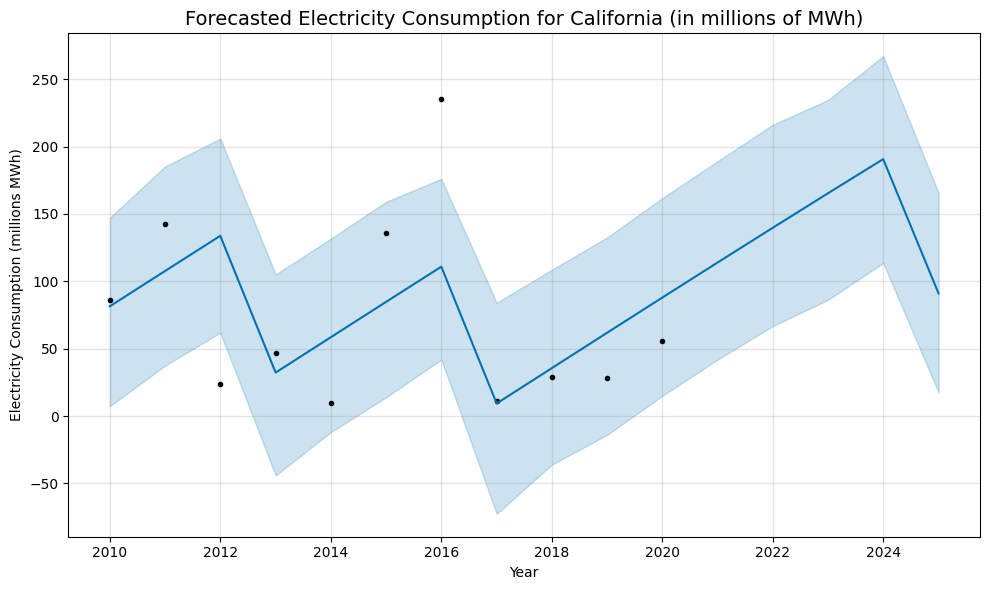

In [61]:
fig = model.plot(forecast)
plt.title(f'Forecasted Electricity Consumption for {state} (in millions of MWh)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Electricity Consumption (millions MWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

### The forecast using Prophet shows a gradually increasing trend in California's electricity consumption over the coming years, suggesting a steady rise in energy demand. While some past data points deviate due to fluctuations, the overall projection indicates consistent growth, which can help inform future energy planning and infrastructure decisions.

# Conclusion

Our analysis of state-level electricity consumption across the United States revealed significant variability in usage patterns among states and over time. Using data from the U.S. Energy Information Administration (EIA), we explored annual consumption trends, identified outlier states with unusually high values (like California and Texas), and visualized how the top-consuming states changed year to year.

We found that certain states, such as California, Texas, and Florida, consistently showed high electricity consumption due to their population size, industrial activity, and climate conditions. Box plots highlighted the presence of extreme values, which were investigated further. Year-over-year line plots showed both growth and volatility in state consumption, and our Prophet-based forecasting for California suggested a moderate upward trend in electricity demand through 2025, albeit with a wide confidence interval.

This analysis underscores the importance of regional consumption patterns in shaping energy policy, planning infrastructure investments, and forecasting future energy demand. Insights from such trends can help utilities and governments optimize supply strategies and support sustainable energy initiatives.

# Recommendations

To address the observed electricity consumption trends, policymakers and energy providers should focus on region-specific strategies. High-consumption states require targeted efficiency initiatives, while forecast insights should guide future infrastructure planning and clean energy investments.

Prioritize efficiency programs in high-demand states like California and Texas.

Use forecast models (e.g., Prophet) to plan grid capacity and investments.

Promote renewable energy in states with rising electricity demand.

Encourage consistent data reporting for accurate analysis and planning.

Customize energy policies based on local demographics, industry, and climate.